## Import Libraries

In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn import metrics

from datetime import datetime

import warnings

# Disable all warnings
warnings.filterwarnings('ignore')


In [32]:
stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2021-03-1'

In [33]:
# Extracting the Stock
yf.pdr_override()
df = pdr.get_data_yahoo(stock_symbol, start_date, end_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349129,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925652,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582649,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750259,132079200
...,...,...,...,...,...,...
2021-02-22,128.009995,129.720001,125.599998,126.000000,123.840347,103916400
2021-02-23,123.760002,126.709999,118.389999,125.860001,123.702721,158273000
2021-02-24,124.940002,125.559998,122.230003,125.349998,123.201462,111039900


In [66]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Visualization

In [34]:
# Splitting the dataset manually
train_df = df.loc['2020-01-01':'2021-01-01']
test_df = df.loc['2021-01-02':'2021-02-01']
validation_df = df.loc['2021-02-02':'2021-03-01']

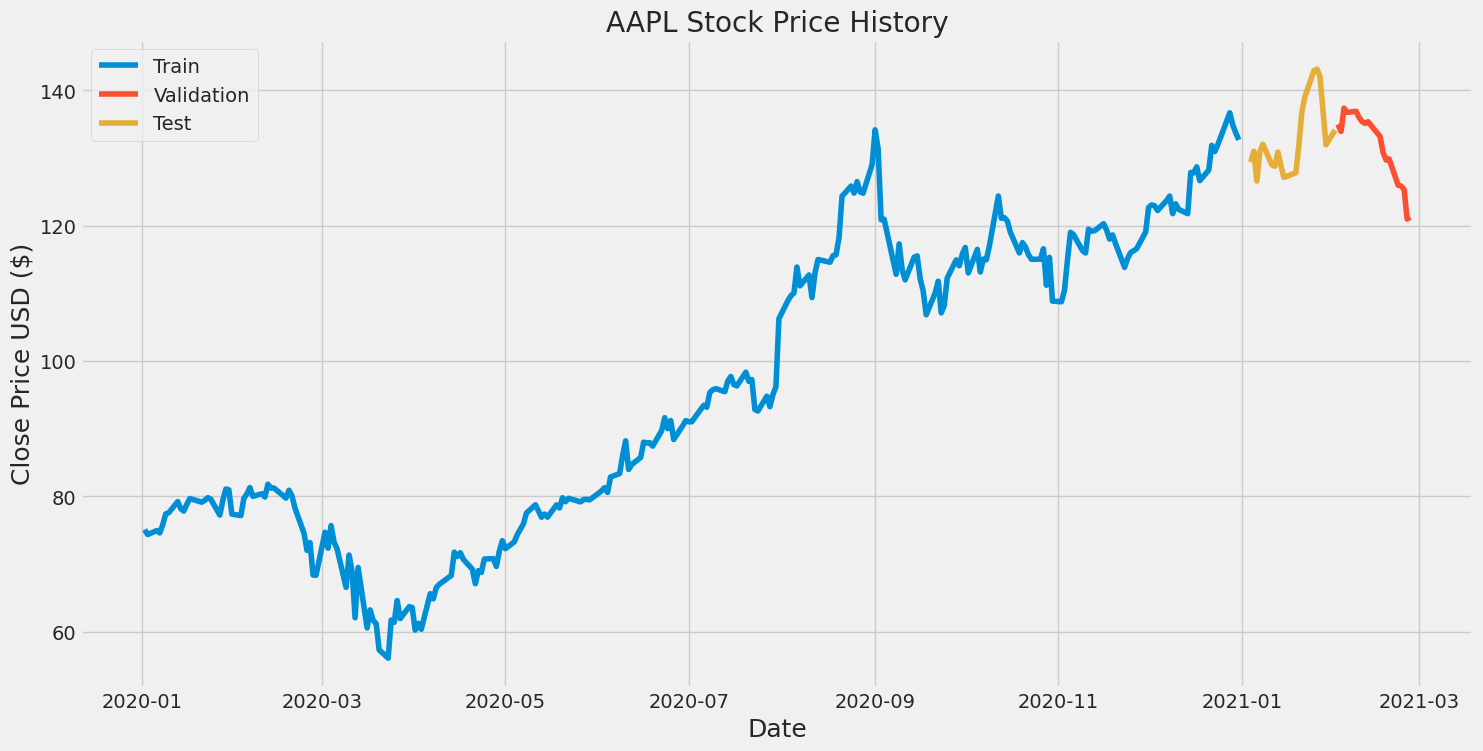

In [65]:
# Plot the entire dataset and mark the train, val and test
plt.figure(figsize=(16,8))
plt.title('AAPL Stock Price History')
plt.plot(train_df['Close'], label='Train')
plt.plot(validation_df['Close'], label='Validation')
plt.plot(test_df['Close'], label='Test')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='upper left')
plt.show()

## Modeling

In [196]:
train_len = train_df.shape[0]

dataset = df.filter(['Close'])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [230]:
train_data = scaled_data[0:int(train_len), :]
# Split the data into x_train and y_train data sets
X_train = []
y_train = []

sequence_length = 30

for i in range(sequence_length, len(train_data)):
    X_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

test_data = scaled_data[train_len - sequence_length: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[train_len:]['Close'].values

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


print(X_train.shape)
print(x_test.shape)


(223, 30, 1)
(38, 30, 1)


In [231]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from keras.losses import Huber

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dropout(0.02))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss=Huber())

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
223/223 [==============================] - 10s 31ms/step - loss: 0.0136
Epoch 2/3
223/223 [==============================] - 11s 51ms/step - loss: 0.0049
Epoch 3/3
223/223 [==============================] - 5s 24ms/step - loss: 0.0043


## Evaluation

In [235]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
print("MAE :",metrics.mean_absolute_error(y_test, predictions))
print("RMSE :",metrics.mean_squared_error(y_test, predictions, squared=False))
print("r2 Score :", metrics.r2_score(y_test, predictions))

2/2 [==============================] - 0s 17ms/step
MAE : 3.341293736508018
RMSE : 4.6452901220483875
r2 Score : 0.8261051398785001


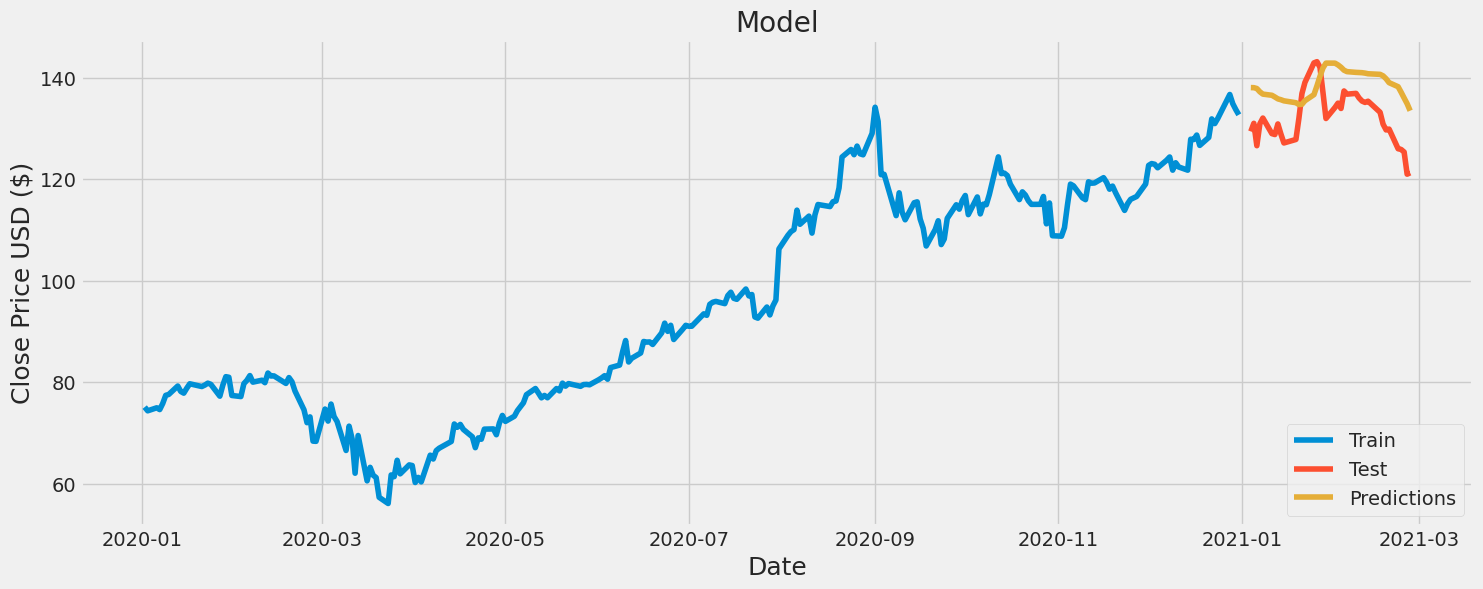

In [222]:
# Plot the data
train = dataset[:train_len]
valid = dataset[train_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()


## Modeling with all input

In [192]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Assuming df is your DataFrame containing all columns including 'Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume'

sequence_length = 7
# Select relevant columns
data = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Convert dataframe to numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = train_len

# Separate the target variable (Close) from features
features = dataset[:, :5]  # Columns 'Open' to 'Adj Close'
target = dataset[:, 3]  # 'Close' column

# Scale the features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = feature_scaler.fit_transform(features)

# Scale the target variable
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

# Create the training data set
train_data = scaled_features[0:int(training_data_len), :]
train_target = scaled_target[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, :])  # Include all columns for the past 60 days
    y_train.append(train_target[i, 0])  # 'Close' column as the target variable

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 5))  # 5 is the number of features

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 5)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss=Huber())

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=4)

Epoch 1/4
246/246 [==============================] - 7s 9ms/step - loss: 0.0040
Epoch 2/4
246/246 [==============================] - 2s 8ms/step - loss: 0.0025
Epoch 3/4
246/246 [==============================] - 2s 9ms/step - loss: 0.0016
Epoch 4/4
246/246 [==============================] - 2s 8ms/step - loss: 0.0013


2/2 [==============================] - 1s 8ms/step
MAE : 3.40454764115183
RMSE : 4.358032991613148
r2 Score : 0.3188585595585376


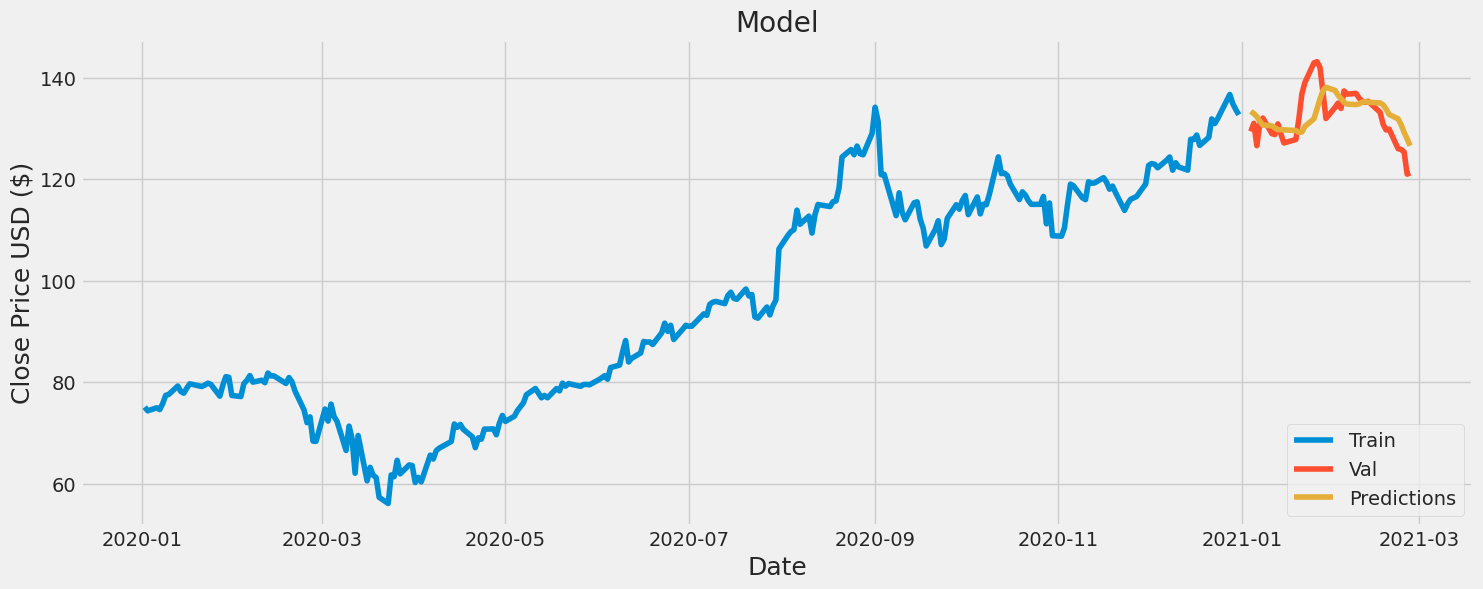

In [193]:
# Create the testing data set
test_data = scaled_features[training_data_len - sequence_length:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, 3]  # 'Close' column as the target variable
for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, :])  # Include all columns for the past 60 days

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 5))  # 5 is the number of features

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = target_scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
print("MAE :",metrics.mean_absolute_error(y_test, predictions))
print("RMSE :",metrics.mean_squared_error(y_test, predictions, squared=False))
print("r2 Score :", metrics.r2_score(y_test, predictions))

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()